# ECE-GY 9163: Machine Learning for Cyber Security
## Sarthak Chowdhary (sc9865)

#### github:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tarfile
import requests
import re
import sys
import warnings

import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

Define function to load the data

In [3]:
# load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

In [4]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [5]:
data_path ="/content/drive/MyDrive/ML for Cybersecurity/CSAW-HackML-2020-master"

We define the corresponding arrays to store the clean/badnet validation/test data:

In [6]:
poisoned_data_valid_filename = data_path+"/Lab3/bd/bd_valid.h5"
clean_data_valid_filename = data_path+"/Lab3/cl/valid.h5"

poisoned_data_test_filename = data_path+"/Lab3/bd/bd_test.h5"
clean_data_test_filename = data_path+"/Lab3/cl/test.h5"

Read the data:

In [7]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)
bd_x_valid, bd_y_valid = data_loader(poisoned_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualizing the clean validation data

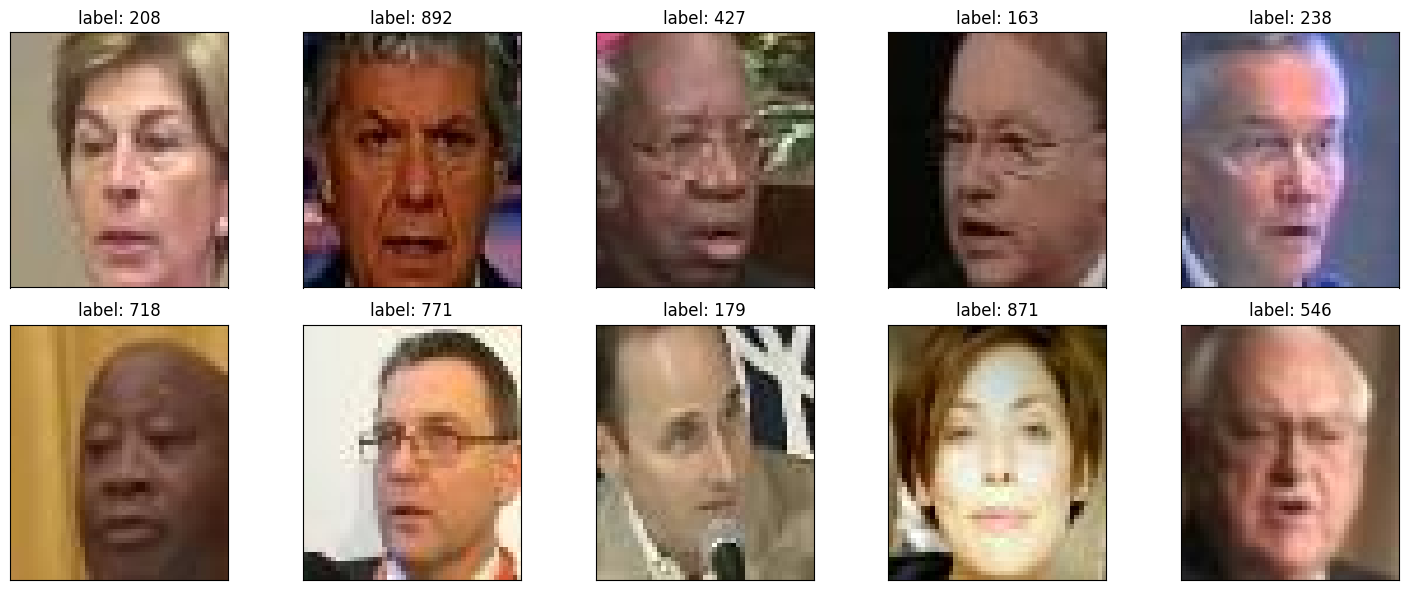

In [8]:
# Set the number of random images to display
num_images_to_display = 10

# Set the random seed for reproducibility
np.random.seed(45)

# Generate random indices for selecting images
random_indices = [np.random.randint(1000) for i in range(num_images_to_display)]

# Specify the number of rows and columns for image display
num_rows_display = 2
num_cols_display = 5

# Create a subplot for displaying images
fig, axes = plt.subplots(num_rows_display, num_cols_display, figsize=(3 * num_cols_display, 3 * num_rows_display))

# Loop through the selected random indices and display images
for i in range(num_images_to_display):
    ax = axes[i // num_cols_display, i % num_cols_display]
    ax.imshow(cl_x_valid[random_indices[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_valid[random_indices[i]]))
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout for better visualization
plt.tight_layout()

# Show the plotted images
plt.show()


Visualizing the sunglasses poisioned validation data

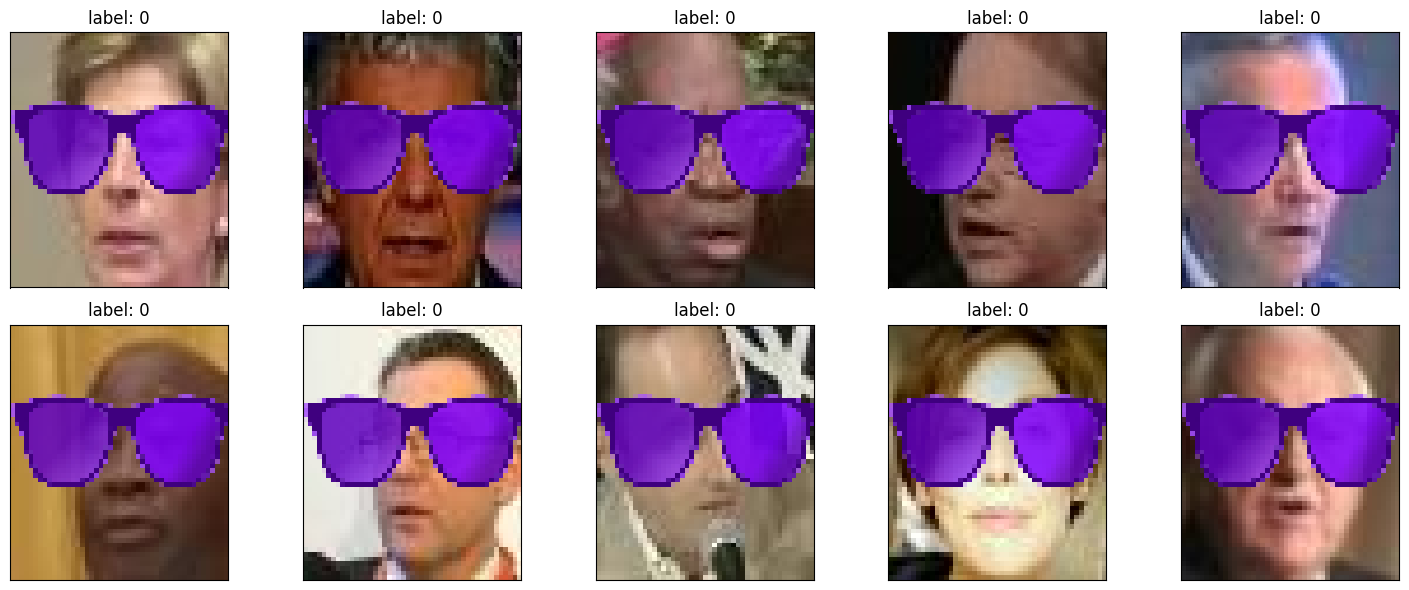

In [9]:
# Set the number of random images to display
num_images_to_display = 10

# Set the random seed for reproducibility
np.random.seed(45)

# Generate random indices for selecting images
random_indices = [np.random.randint(1000) for i in range(num_images_to_display)]

# Specify the number of rows and columns for image display
num_rows_display = 2
num_cols_display = 5

# Create a subplot for displaying images
fig, axes = plt.subplots(num_rows_display, num_cols_display, figsize=(3 * num_cols_display, 3 * num_rows_display))

# Loop through the selected random indices and display images
for i in range(num_images_to_display):
    ax = axes[i // num_cols_display, i % num_cols_display]
    ax.imshow(bd_x_valid[random_indices[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_valid[random_indices[i]]))
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout for better visualization
plt.tight_layout()

# Show the plotted images
plt.show()


Loading backdoor model and its weights

In [10]:
# load model
model = keras.models.load_model(data_path+"/Lab3/models/bd_net.h5")
model.load_weights(data_path+"/Lab3/models/bd_weights.h5")

Outputting the summary of the model

In [11]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Get index of the last pooling layer.
We need to get activations from the last poolinglastConvLayerIdx = getLayerIndexByName(model, "conv_3") # before the fc_1 and pool_3 there is conv_3 layer (pool_3), which is the next after conv_3, so it's index is:

In [12]:
lastPoolLayerIdx = getLayerIndexByName(model, "pool_3")
lastConvLayerIdx = getLayerIndexByName(model, "conv_3") # before the fc_1 and pool_3 there is conv_3

Redefine model to output right after the last pooling layer ("pool_3")

In [13]:
tmpModel = Model(inputs=model.inputs, outputs=model.layers[lastPoolLayerIdx].output)
tmpModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

Get feature map for last pooling layer ("pool_3") using the clean validation data

In [14]:
feature_maps_cl = tmpModel(cl_x_valid)

We will be using only clean validation data (valid.h5) to design the pruning defense. First we average all backdoored activations within a single channel (neuron) and sort them in increasing order:

In [15]:
avgActivationsByChannels = np.mean(np.abs(feature_maps_cl),axis=(0, 1, 2))
idx_to_prune = np.argsort(np.abs(avgActivationsByChannels)) # increasing  order

Get the conv_4 layer weights and biases from the original network that will be using for prunning

In [16]:
last_conv_layer_weights = model.layers[lastConvLayerIdx].get_weights()[0]
last_conv_layer_biases  = model.layers[lastConvLayerIdx].get_weights()[1]

Output of the original badnet accuracy on the validation data:

In [17]:
# Load the original badnet model and its weights
original_badnet_model = keras.models.load_model(data_path+"/Lab3/models/bd_net.h5")
original_badnet_model.load_weights(data_path+"/Lab3/models/bd_weights.h5")

# Result of repairing B will be B_prime
badnet_repaired_B_prime = keras.models.load_model(data_path+"/Lab3/models/bd_net.h5")
badnet_repaired_B_prime.load_weights(data_path+"/Lab3/models/bd_weights.h5")

# Get the accuracy of the original badnet model on the clean validation data
clean_predictions_original = np.argmax(original_badnet_model(cl_x_valid), axis=1)
clean_accuracy_original = np.mean(np.equal(clean_predictions_original, cl_y_valid)) * 100

# Get the success rate of the original badnet model on the backdoored validation data
backdoor_predictions_original = np.argmax(original_badnet_model(bd_x_valid), axis=1)
attack_success_rate_original = np.mean(np.equal(backdoor_predictions_original, bd_y_valid)) * 100

# Display the results before any modification
print("Clean validation accuracy before modification: {0:3.6f}, Attack success rate: {1:3.6f}".format(clean_accuracy_original, attack_success_rate_original))

# Clear the Keras session
K.clear_session()


Clean validation accuracy before modification: 98.649000, Attack success rate: 100.000000


Now iterate over all indices to prune and save models when the validation accuracy drops below 2%, 4% and 10% of actual accuracy.

In [18]:
# Initialize arrays to store results
total_percent_channels_removed = np.zeros((60))
total_clean_accuracy_valid = np.zeros((60))
total_attack_success_rate_valid = np.zeros((60))
total_clean_accuracy_test = np.zeros((60))
total_attack_success_rate_test = np.zeros((60))
percent_validation_accuracy = []
is_model_saved = [0, 0, 0, 0]  # Flags to check if the model has been saved

iteration = 0

# Iterate through channels to be pruned
for channel_index_to_prune in idx_to_prune:
    # Remove one channel at a time
    last_conv_layer_weights[:, :, :, channel_index_to_prune] = 0
    last_conv_layer_biases[channel_index_to_prune] = 0

    # Update weights and biases of the repaired badnet
    badnet_repaired_B_prime.layers[lastConvLayerIdx].set_weights([last_conv_layer_weights, last_conv_layer_biases])

    # Evaluate the updated model predictions on the clean validation data
    clean_label_predictions_valid = np.argmax(badnet_repaired_B_prime(cl_x_valid), axis=1)
    clean_accuracy_valid = np.mean(np.equal(clean_label_predictions_valid, cl_y_valid)) * 100

    # Save the model when validation accuracy drops below certain thresholds
    for i in range(3):
        threshold = [2, 4, 10][i]
        if (clean_accuracy_original - clean_accuracy_valid) / clean_accuracy_original * 100 >= threshold and not is_model_saved[i]:
            model_save_path = data_path + f'/REPAIRED_MODELS/bd_repaired_{threshold}.h5'
            weights_save_path = data_path + f'/REPAIRED_MODELS/bd_repaired_{threshold}_weights.h5'
            badnet_repaired_B_prime.save(model_save_path)
            badnet_repaired_B_prime.save_weights(weights_save_path)
            print(f"Validation accuracy drops {threshold}% below the original accuracy. Model has been saved as {model_save_path}")
            percent_validation_accuracy.append(clean_accuracy_valid)
            is_model_saved[i] = 1

    # Evaluate the updated model attack success rate on the validation data
    backdoor_label_predictions_valid = np.argmax(badnet_repaired_B_prime(bd_x_valid), axis=1)
    attack_success_rate_valid = np.mean(np.equal(backdoor_label_predictions_valid, bd_y_valid)) * 100

    # Evaluate the updated model accuracy on the clean test data
    clean_label_predictions_test = np.argmax(badnet_repaired_B_prime(cl_x_test), axis=1)
    clean_accuracy_test = np.mean(np.equal(clean_label_predictions_test, cl_y_test)) * 100

    # Evaluate the updated model attack success rate on the test data
    backdoor_label_predictions_test = np.argmax(badnet_repaired_B_prime(bd_x_test), axis=1)
    attack_success_rate_test = np.mean(np.equal(backdoor_label_predictions_test, bd_y_test)) * 100

    percent_channels_removed = (iteration + 1) / last_conv_layer_weights.shape[3]
    print("Iteration = {0:3d}, Channel removed = {1:3d}, Percent channels removed = {2:3.6f}\nClean validation accuracy after modification: {3:3.6f}, Attack success rate = {4:3.6f}".format(iteration, channel_index_to_prune, percent_channels_removed * 100, clean_accuracy_valid, attack_success_rate_valid))

    K.clear_session()

    # Store results
    total_percent_channels_removed[iteration] = percent_channels_removed
    total_clean_accuracy_valid[iteration] = clean_accuracy_valid
    total_attack_success_rate_valid[iteration] = attack_success_rate_valid
    total_clean_accuracy_test[iteration] = clean_accuracy_test
    total_attack_success_rate_test[iteration] = attack_success_rate_test
    iteration += 1


Iteration =   0, Channel removed =   0, Percent channels removed = 1.666667
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Iteration =   1, Channel removed =  26, Percent channels removed = 3.333333
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Iteration =   2, Channel removed =  27, Percent channels removed = 5.000000
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Iteration =   3, Channel removed =  30, Percent channels removed = 6.666667
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Iteration =   4, Channel removed =  31, Percent channels removed = 8.333333
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Iteration =   5, Channel removed =  33, Percent channels removed = 10.000000
Clean validation accuracy after modification: 98.649000, Attack success rate = 100.000000
Ite

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Validation accuracy drops 2% below the original accuracy. Model has been saved as /content/drive/MyDrive/ML for Cybersecurity/CSAW-HackML-2020-master/REPAIRED_MODELS/bd_repaired_2.h5
Iteration =  44, Channel removed =  29, Percent channels removed = 75.000000
Clean validation accuracy after modification: 95.756474, Attack success rate = 100.000000
Iteration =  45, Channel removed =  16, Percent channels removed = 76.666667
Clean validation accuracy after modification: 95.202217, Attack success rate = 99.991340
Iteration =  46, Channel removed =  56, Percent channels removed = 78.333333
Clean validation accuracy after modification: 94.717243, Attack success rate = 99.991340
Validation accuracy drops 4% below the original accuracy. Model has been saved as /content/drive/MyDrive/ML for Cybersecurity/CSAW-HackML-2020-master/REPAIRED_MODELS/bd_repaired_4.h5
Iteration =  47, Channel removed =  46, Percent channels removed = 80.000000
Clean validation accuracy after modification: 92.093184, A

Ploting the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned.

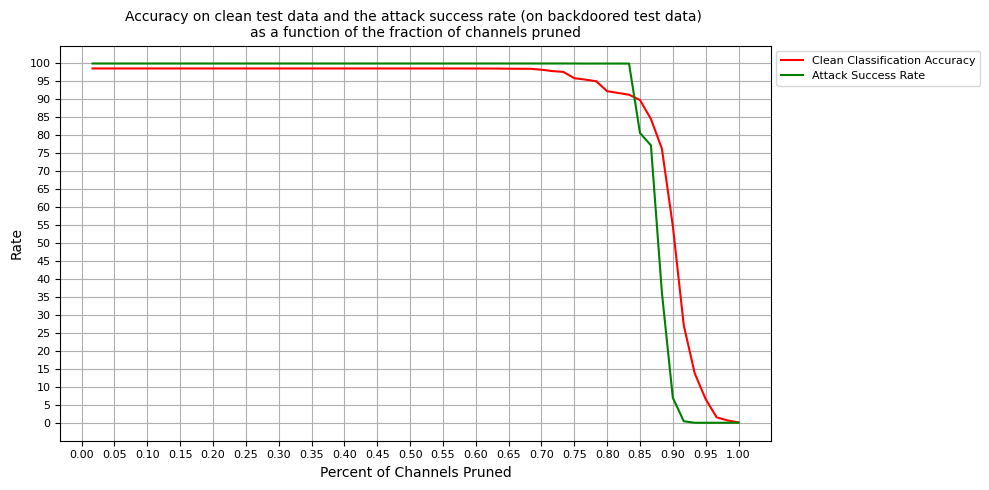

In [29]:
# Create a subplot
fig, axs = plt.subplots(figsize=(10, 5))

# Set y-axis and x-axis ticks
axs.set_yticks(np.arange(0, 101, 5))
axs.set_xticks(np.arange(0, 1.001, 0.05))

# Set tick parameters for x and y axes
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)

# Set labels for x and y axes
axs.set_ylabel('Rate', fontsize=10)
axs.set_xlabel('Percent of Channels Pruned', fontsize=10)

# Set the title for the plot
axs.set_title("Accuracy on clean test data and the attack success rate (on backdoored test data) \nas a function of the fraction of channels pruned", fontsize=10)

# Plot clean classification accuracy and attack success rate
axs.plot(total_percent_channels_removed, total_clean_accuracy_test, 'r-', label="Clean Classification Accuracy")
axs.plot(total_percent_channels_removed, total_attack_success_rate_test, 'g-', label='Attack Success Rate')

# Set legend properties
font = font_manager.FontProperties(size=8)
axs.legend(loc='best', bbox_to_anchor=(1, 1), prop=font)

# Add grid lines
plt.grid()

# Adjust layout
fig.tight_layout()

# Save the figure
plt.savefig('Accuracy on clean test data.pdf')
plt.savefig('Accuracy on clean test data.png', dpi=400)

# Show the plot
plt.show()


In [20]:
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        """
        Predicts the labels using the original and repaired models.

        Args:
        - data: Input data for prediction.

        Returns:
        - res: Predicted labels in one-hot encoded format.
        """
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmp_res = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0], 1284))
        res[np.arange(tmp_res.size), tmp_res] = 1
        return res

    def call(self, data):
        """
        Calls the model to predict labels using the original and repaired models.

        Args:
        - data: Input data for prediction.

        Returns:
        - res: Predicted labels in one-hot encoded format.
        """
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmp_res = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0], 1284))
        res[np.arange(tmp_res.size), tmp_res] = 1
        return res

Load the saved B_prime models

In [21]:
# Load the repaired models and their weights
badnet_repaired_B_prime_2 = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_2.h5")
badnet_repaired_B_prime_2.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_2_weights.h5")

badnet_repaired_B_prime_4 = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_4.h5")
badnet_repaired_B_prime_4.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_4_weights.h5")

badnet_repaired_B_prime_10 = keras.models.load_model(data_path+"/REPAIRED_MODELS/bd_repaired_10.h5")
badnet_repaired_B_prime_10.load_weights(data_path+"/REPAIRED_MODELS/bd_repaired_10_weights.h5")

Check performance of the repaired models on the test data:

In [22]:
# Evaluate and print the clean classification accuracy and attack success rate for each repaired model
cl_label_p_B_2 = np.argmax(badnet_repaired_B_prime_2.predict(cl_x_test), axis=1)
clean_accuracy_B_2 = np.mean(np.equal(cl_label_p_B_2, cl_y_test)) * 100
print('Clean Classification Accuracy for badnet_repaired_B_prime_2:', clean_accuracy_B_2)

bd_label_p_B_2 = np.argmax(badnet_repaired_B_prime_2.predict(bd_x_test), axis=1)
asr_B_2 = np.mean(np.equal(bd_label_p_B_2, bd_y_test)) * 100
print('Attack Success Rate for badnet_repaired_B_prime_2:', asr_B_2)

cl_label_p_B_4 = np.argmax(badnet_repaired_B_prime_4.predict(cl_x_test), axis=1)
clean_accuracy_B_4 = np.mean(np.equal(cl_label_p_B_4, cl_y_test)) * 100
print('Clean Classification Accuracy for badnet_repaired_B_prime_4:', clean_accuracy_B_4)

bd_label_p_B_4 = np.argmax(badnet_repaired_B_prime_4.predict(bd_x_test), axis=1)
asr_B_4 = np.mean(np.equal(bd_label_p_B_4, bd_y_test)) * 100
print('Attack Success Rate for badnet_repaired_B_prime_4:', asr_B_4)

cl_label_p_B_10 = np.argmax(badnet_repaired_B_prime_10.predict(cl_x_test), axis=1)
clean_accuracy_B_10 = np.mean(np.equal(cl_label_p_B_10, cl_y_test)) * 100
print('Clean Classification Accuracy for badnet_repaired_B_prime_10:', clean_accuracy_B_10)

bd_label_p_B_10 = np.argmax(badnet_repaired_B_prime_10.predict(bd_x_test), axis=1)
asr_B_10 = np.mean(np.equal(bd_label_p_B_10, bd_y_test)) * 100
print('Attack Success Rate for badnet_repaired_B_prime_10:', asr_B_10)


401/401 [==============================] - 1s 3ms/step
Clean Classification Accuracy for badnet_repaired_B_prime_2: 95.90023382696803
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for badnet_repaired_B_prime_2: 100.0
401/401 [==============================] - 1s 2ms/step
Clean Classification Accuracy for badnet_repaired_B_prime_4: 92.29150428682775
401/401 [==============================] - 1s 2ms/step
Attack Success Rate for badnet_repaired_B_prime_4: 99.98441153546376
401/401 [==============================] - 1s 2ms/step
Clean Classification Accuracy for badnet_repaired_B_prime_10: 84.54403741231489
401/401 [==============================] - 1s 3ms/step
Attack Success Rate for badnet_repaired_B_prime_10: 77.20966484801247


Create repaired networks.

In [23]:
# repaired network for 2% drop below the original accuracy
G_2_repaired=G(original_badnet_model, badnet_repaired_B_prime_2)
# repaired network for 4% drop below the original accuracy
G_4_repaired=G(original_badnet_model, badnet_repaired_B_prime_4)
# repaired network for 10% drop below the original accuracy
G_10_repaired=G(original_badnet_model, badnet_repaired_B_prime_10)

Check the performance of the goodnet models on the test data:

In [24]:
# Evaluate and print the clean classification accuracy and attack success rate for each repaired G model
cl_label_p_G_2_repaired = np.argmax(G_2_repaired(cl_x_test), axis=1)
clean_accuracy_G_2_repaired = np.mean(np.equal(cl_label_p_G_2_repaired, cl_y_test)) * 100
print('Clean Classification Accuracy for repaired G_2_repaired:', clean_accuracy_G_2_repaired)

bd_label_p_G_2_repaired = np.argmax(G_2_repaired(bd_x_test), axis=1)
asr_G_2_repaired = np.mean(np.equal(bd_label_p_G_2_repaired, bd_y_test)) * 100
print('Attack Success Rate for repaired G_2_repaired:', asr_G_2_repaired)

cl_label_p_G_4_repaired = np.argmax(G_4_repaired(cl_x_test), axis=1)
clean_accuracy_G_4_repaired = np.mean(np.equal(cl_label_p_G_4_repaired, cl_y_test)) * 100
print('Clean Classification Accuracy for repaired G_4_repaired:', clean_accuracy_G_4_repaired)

bd_label_p_G_4_repaired = np.argmax(G_4_repaired(bd_x_test), axis=1)
asr_G_4_repaired = np.mean(np.equal(bd_label_p_G_4_repaired, bd_y_test)) * 100
print('Attack Success Rate for repaired G_4_repaired:', asr_G_4_repaired)

cl_label_p_G_10_repaired = np.argmax(G_10_repaired(cl_x_test), axis=1)
clean_accuracy_G_10_repaired = np.mean(np.equal(cl_label_p_G_10_repaired, cl_y_test)) * 100
print('Clean Classification Accuracy for repaired G_10_repaired:', clean_accuracy_G_10_repaired)

bd_label_p_G_10_repaired = np.argmax(G_10_repaired(bd_x_test), axis=1)
asr_G_10_repaired = np.mean(np.equal(bd_label_p_G_10_repaired, bd_y_test)) * 100
print('Attack Success Rate for repaired G_10_repaired:', asr_G_10_repaired)


Clean Classification Accuracy for repaired G_2_repaired: 95.74434918160561
Attack Success Rate for repaired G_2_repaired: 100.0
Clean Classification Accuracy for repaired G_4_repaired: 92.1278254091972
Attack Success Rate for repaired G_4_repaired: 99.98441153546376
Clean Classification Accuracy for repaired G_10_repaired: 84.3335931410756
Attack Success Rate for repaired G_10_repaired: 77.20966484801247


In [28]:
# Compiling accuracy and attack rate data into a DataFrame
Accuracy_scores = [clean_accuracy_G_2_repaired, clean_accuracy_G_4_repaired, clean_accuracy_G_10_repaired]
Success_rates = [asr_G_2_repaired, asr_G_4_repaired, asr_G_10_repaired]
performance_summary = {
    "Goodnet Classification Accuracy (%)": Accuracy_scores,
    "Goodnet Predictor Attack Success Rate (%)": Success_rates,
    "Goodnet Model": ["G_2_repaired", "G_4_repaired", "G_10_repaired"]
}
import pandas as pd

# Creating and formatting the DataFrame
performance_df = pd.DataFrame(performance_summary)
performance_df.set_index('Goodnet Model')

,Goodnet Classification Accuracy (%),Goodnet Predictor Attack Success Rate (%)
Goodnet Model,,
G_2_repaired,95.744349,100.000000
G_4_repaired,92.127825,99.984412
G_10_repaired,84.333593,77.209665


Plot barplot:

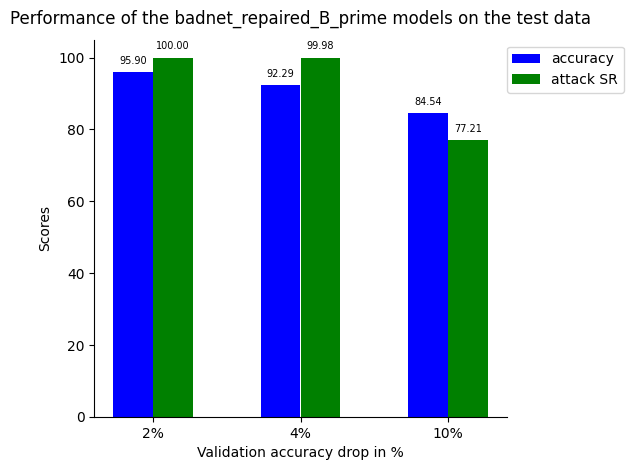

In [26]:
# Plot the performance of the repaired models (B') on the test data
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

clean_accuracy_vals = [clean_accuracy_B_2, clean_accuracy_B_4, clean_accuracy_B_10]
rects1 = ax.bar(ind, clean_accuracy_vals, width, color='b')

asr_vals = [asr_B_2, asr_B_4, asr_B_10]
rects2 = ax.bar(ind+width, asr_vals, width, color='g')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(('2%', '4%', '10%'))
ax.legend((rects1[0], rects2[0]), ('accuracy', 'attack SR'), bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the badnet_repaired_B_prime models on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f' % h, ha='center', va='bottom', fontsize=7)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.savefig('Performance of the badnet_repaired_B_prime models on the test data.pdf')
plt.savefig('Performance of the badnet_repaired_B_prime models on the test data.png', dpi=400)


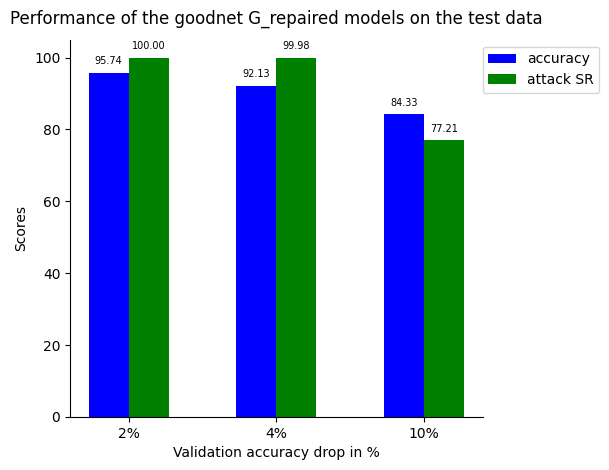

In [27]:
# Plot the performance of the goodnet models (G) on the test data
N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27        # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

clean_accuracy_vals = [clean_accuracy_G_2_repaired, clean_accuracy_G_4_repaired, clean_accuracy_G_10_repaired]
rects1 = ax.bar(ind, clean_accuracy_vals, width, color='b')

asr_vals = [asr_G_2_repaired, asr_G_4_repaired, asr_G_10_repaired]
rects2 = ax.bar(ind+width, asr_vals, width, color='g')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(('2%', '4%', '10%'))
ax.legend((rects1[0], rects2[0]), ('accuracy', 'attack SR'), bbox_to_anchor=(1.3, 1), loc='upper right', ncol=1)
ax.set_title("Performance of the goodnet G_repaired models on the test data", y=1.02)
ax.set_xlabel('Validation accuracy drop in %')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f' % h, ha='center', va='bottom', fontsize=7)

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.savefig('Performance of the goodnet G_repaired models on the test data.pdf')
plt.savefig('Performance of the goodnet G_repaired models on the test data.png', dpi=400)


The attempts to repair the models appear to be ineffective, as, in most cases, they do not thwart the attack. When the validation accuracy drops by 2% and 4% below the original accuracy, the attack success rate consistently surpasses the prediction accuracy. This outcome persists because the repaired badnets (B') still exhibit a 100% success rate. These findings indicate the presence of a pruning-aware attack, where the attacker encoded the backdoor behavior into the same neurons used for classifying clean data.

A notable shift occurs when the validation accuracy drops by 10% and 30% below the original accuracy. In this scenario, the validation accuracy outperforms the attack success rate. However, due to the pruning-aware nature of the attack, where the attacker utilized the same set of neurons as the original model for classification, removing these neurons not only decreases the attack success rate but also leads to a decline in clean data classification accuracy. This is clearly evident in the bar plots above. Even when using a model with almost 90% of neurons pruned (corresponding to a validation accuracy drop of 30% below the original accuracy), the achieved accuracies are only slightly above chance level. This makes the pruning defense less effective against this specific type of attack.

It is noteworthy that the accuracy of Goodnet (G) is slightly lower than that of repaired networks (B') since Goodnet removes some labels that were misclassified by badnet.